# Determination of M^2 beam quality factor 

This code was written to estimate the M^2 beam quality factor of a laser. The basic function is as follows:
* Read in a series of images containing the intensity profile 
* Perform simple averaging denoising
* Perform gaussian fitting on the x and y lines passing through the center of the beam spot
* Extract the widths for fits and perform fit according to caustic formula
* Extract M^2 value from fit and plot measured widths and fits vs distance

In [2]:
from scipy.misc import imread
from scipy.optimize import least_squares
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.ndimage.filters import convolve

In [3]:
path = ("180222_G3") #The folder which contains the image files
ext = ".jpg" #extension of the images
files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))
         and f[-len(ext):] == ext] #Returns a list of all files of given extension in the selected folder
files = sorted(files)
calibration = imread(path + "/calibration/00.jpg")
images = [(imread(path + "/"+ f,mode="L").astype(float)
           - calibration.astype(float)) for f in files]
          #Read all image files into a single list, remove static noise
leny,lenx = calibration.shape

In [4]:
size = 2 #simple averaging noise removal
B = np.ones((size, size))
B /= B.sum()
images = [convolve(image.astype(np.float32), B) for image in images]

In [5]:
mindicies = [np.unravel_index(image.argmax(),image.shape) 
             for image in images]                         #returns a list of tuples containing 
                                                          #the incicies of the horizontal and 
                                                          #verticle lines whose sum is largest
                                                          #(i.e the indicies of the center)
maxlines = [(image[index[0]],image.T[index[1]])
            for image,index in zip(images,mindicies)]     #returns a list of tuples containing
                                                          #the lines corresponding to the indicies
                                                          #gathered in the previous line

In [6]:
testwidth = 100
def gaussian(var,x,y): #Equation of a 2-d Gaussian for lsq
    return var[0] * np.exp(-2 * ((x-var[1]) / var[2])**2) - y + var[3]
def caustic(var,z,y): #Equation of the beam caustic for lsq
    return np.sqrt(var[0]**2 + ((var[1]*(0.6328e-6)*(z-var[2]))/(3.141*var[0]))**2) - y
def lsq_gauss(line,length): #lsq function for gaussian
    return least_squares(gaussian,[np.max(line),np.argmax(line),testwidth,np.min(line)]
                         ,loss = "soft_l1",f_scale=0.1,max_nfev = 1000,args = (np.arange(length),line))
def lsq_caustic(radii): #lsq function for beam caustic
    return least_squares(caustic, [np.average(radii),1.2,20e-3]
                         ,loss = "soft_l1",f_scale=0.1,args = (z,radii),max_nfev = 1000)

In [14]:
fits = [(lsq_gauss(linepair[0],lenx),
         lsq_gauss(linepair[1],leny)) for linepair in maxlines]
                                                                #returns a list of tuples 

In [8]:
z = 5*np.arange(0,20)
z = np.concatenate((z,10*np.arange(1,11) + z[-1]))
z = np.concatenate((z,50*np.arange(1,6) + z[-1]))
z = z*1e-3

In [9]:
radii_x = [abs(5.2*fit[0].x[2]*1e-6) for fit in fits]
radii_y = [abs(5.2*fit[1].x[2]*1e-6) for fit in fits]
caustic_fit_x = lsq_caustic(radii_x)
caustic_fit_y = lsq_caustic(radii_y)

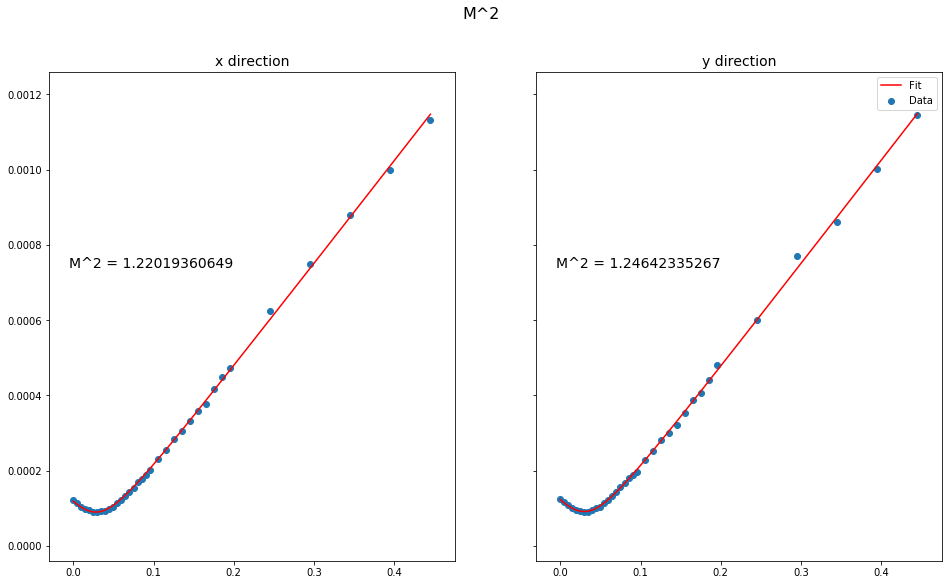

In [22]:
f, ax = plt.subplots(1, 2, sharey=True)
f.suptitle("M^2",fontsize = 16)
f.set_size_inches(16, 9)
ax[0].set_title("x direction",fontsize = 14)
ax[1].set_title("y direction",fontsize = 14)

ax[0].scatter(z,radii_x)
ax[0].plot(z,caustic(caustic_fit_x.x[:4],z,0),c = "red")
ax[0].text(0.05,0.6,"M^2 = " + str(caustic_fit_x.x[1]),fontsize = 14,transform=ax[0].transAxes)

ax[1].scatter(z,radii_y, label = "Data")
ax[1].plot(z,caustic(caustic_fit_y.x[:4],z,0),c = "red",label = "Fit")
ax[1].text(0.05,0.6,"M^2 = " + str(caustic_fit_y.x[1]),fontsize = 14,transform=ax[1].transAxes)

rmin = np.min(radii_x)
rmax = np.max(radii_x)
rint = rmax - rmin
plt.ylim(rmin - rint/8,rmax + rint/8)
plt.legend()
plt.savefig("Caustic.eps",format = "eps")
plt.show()

In [16]:
m2avg = (caustic_fit_x.x[1] + caustic_fit_y.x[1])/2
print("The average M^2 value is " + str(m2avg))

The average M^2 value is 1.23330847958
